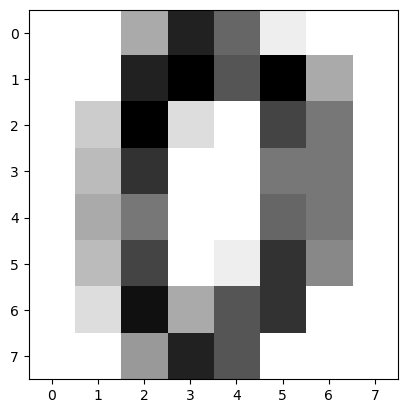

In [29]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

In [30]:
n_samples = len(digits.images)
data = digits.images

In [32]:
X_train,X_test,y_train,y_test = train_test_split(data, digits.target,test_size=0.2)

print(X_train.shape)
print(digits.target)

(1437, 8, 8)
[0 1 2 ... 8 9 8]


In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# TensorDataset으로 래핑
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) 
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1) 
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(y_train_tensor)

tensor([7, 2, 5,  ..., 8, 0, 5])


In [ ]:
import torch.nn as nn
import torch.optim as optim

# 분류 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
    
        # in_channels	입력 이미지의 채널 수 흑백이면 1, RGB면 3
        # out_channels	필터 개수 = 출력 feature map의 채널 수, 이 수만큼 다른 특징 추출
        # kernel_size	필터 크기: 3×3을 사용함
        # padding	출력 크기를 입력과 같게 유지하기 위한 여백 추가

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # -> (16, 8, 8)
        self.pool = nn.MaxPool2d(2, 2)  # -> (16, 4, 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # -> (32, 4, 4)
        # -> (32, 2, 2)
      
        self.fc1 = nn.Linear(32 * 2 * 2, 64) # 32 * 2 * 2 -> CNN의 합성곱 계층과 풀링 계층을 거친 후의 feature map 크기를 계산 한 것 
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))  
        x = self.pool(x)              
        x = torch.relu(self.conv2(x))  
        x = self.pool(x)               
        x = x.view(-1, 32 * 2 * 2)     # flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# GPU 사용, 없으면 cpu 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
# 학습 루프
model.train()
for epoch in range(50):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 2.0499
Epoch 2, Loss: 0.8788
Epoch 3, Loss: 0.3358
Epoch 4, Loss: 0.2285
Epoch 5, Loss: 0.1552
Epoch 6, Loss: 0.1140
Epoch 7, Loss: 0.0874
Epoch 8, Loss: 0.0918
Epoch 9, Loss: 0.0640
Epoch 10, Loss: 0.0558
Epoch 11, Loss: 0.0389
Epoch 12, Loss: 0.0315
Epoch 13, Loss: 0.0375
Epoch 14, Loss: 0.0288
Epoch 15, Loss: 0.0232
Epoch 16, Loss: 0.0184
Epoch 17, Loss: 0.0133
Epoch 18, Loss: 0.0121
Epoch 19, Loss: 0.0073
Epoch 20, Loss: 0.0049
Epoch 21, Loss: 0.0049
Epoch 22, Loss: 0.0051
Epoch 23, Loss: 0.0039
Epoch 24, Loss: 0.0034
Epoch 25, Loss: 0.0089
Epoch 26, Loss: 0.0275
Epoch 27, Loss: 0.0063
Epoch 28, Loss: 0.0032
Epoch 29, Loss: 0.0021
Epoch 30, Loss: 0.0018
Epoch 31, Loss: 0.0022
Epoch 32, Loss: 0.0013
Epoch 33, Loss: 0.0012
Epoch 34, Loss: 0.0011
Epoch 35, Loss: 0.0010
Epoch 36, Loss: 0.0009
Epoch 37, Loss: 0.0008
Epoch 38, Loss: 0.0008
Epoch 39, Loss: 0.0007
Epoch 40, Loss: 0.0007
Epoch 41, Loss: 0.0006
Epoch 42, Loss: 0.0006
Epoch 43, Loss: 0.0005
Epoch 44, Loss: 0.00

In [37]:
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import torch

# 평가
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 예측
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1) 

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())


# 평가 지표 출력
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds,  average='macro')
f1 = f1_score(all_labels,all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")

Accuracy     : 0.9833
Precision    : 0.9828
Recall       : 0.9863
F1 Score     : 0.9843
